# Evaluate Delay Periods

Here, want to evaluate what delay thresholds to allow between defined meteorological states and disaster reports. Procedure is toe evaluate the definitions for a range of delays and optimize the POD. 

## Set up

In [1]:
#--- Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy  as np

from pandas.tseries.offsets import *
from scipy.stats import beta

In [2]:
# place graphics in the notebook document
%matplotlib inline

# use 'casual' graphic style
_ = plt.xkcd()

# set more style defaults
sns.set_palette('deep')

In [3]:
#--- Load data
# read file of observed meteorological events
warnings = pd.read_pickle('../data/event_sequences.pkl')
# read file of reported heatwaves
disrec = pd.read_csv('../data/Heatwaves_database.csv')
# repair region name with space before name
disrec.loc[disrec.Region==' Tamil Nadu','Region'] = 'Tamil Nadu'

In [4]:
#--- Define functions for evaluating distributions 

# ==============================================================
# Function to calculate the mode of the beta distribution
def mode(z) :
    if (z[0]>1) & (z[1]>1) :
        return (z[0]-1)/(z[0]+z[1]-2)
    elif (z[0]>1) & (z[1] < 1) :
        return 1.0
    else :
        return 0.0
# ==============================================================

# ==============================================================
# Functions to calculate the 95%interval of the beta distribution
def credint_low(z) :
    return beta.ppf(0.05, z[0], z[1])

def credint_upp(z) :
    return beta.ppf(0.95, z[0], z[1])
# ==============================================================



## Calculate statistics

In [5]:
#--- See how DesInvetar reports correspond to time periods marked as dangerous   
# list out regions (in '_' instead of ' ' format used in data frame)
regions = ["_".join(x.title().split()) for x in set(disrec.Region.where(disrec.Country=='India')) 
           if str(x) != 'nan']
# choose max number of days to link to warning
max_thrs = 15
# loop over regions 
for region in regions :
    print('---------\n\n')
    print(region)
    print('---------')
    # list dates of heat disasters reported for the region (need to use name format with spaces)
    dis_dates = set(disrec['Date (YMD)'].where(disrec.Region == ' '.join(region.split('_'))))
    # remove nans (from regions that aren't in the selected country 
    dis_dates = [x for x in dis_dates if str(x) != 'nan']
    # check for bad dates
    bd = list()
    for i in range(len(dis_dates)) :
        if (dis_dates[i].split("/")[2] == '0') :
            bd.extend([i])
    # remove bad dates
    for i in sorted(bd, reverse=True):
        dis_dates.pop(i)
    # set as date object
    dis_dates = pd.to_datetime(dis_dates,format='%Y/%m/%d')
    # loop through definitions 
    definitions = list(warnings[region].columns)
    for deflab in definitions :
        print(deflab)
        # loop over different impact/reporting delay thresholds
        for dely_thrs in range(1,max_thrs) :
            # start counters 
            detc = 0 ; falm = 0 ; flag = 0 ; reps = 0
            event_dates = []
            # loop through reports
            for i in range(len(dis_dates)) :
                # something bad has been reported
                reps += 1
                # consider the range of possible dates for 'event'
                event_range = pd.date_range(end=dis_dates[i],freq='D',periods=dely_thrs)
                # keep track of all possible dates
                event_dates.extend(event_range)
                # was it expected?
                if ( max(warnings[region][deflab][event_range]) == 1 ) :
                    detc += 1
            # loop through days that had a warning
            warnings[region]['date'] = warnings[region].index
            for d in warnings[region]['date'][~(warnings[region]['date'].where(warnings[region][deflab] == 1)).isnull()] :
                # a day got flagged with a warning
                flag += 1 
                # is there any reason to believe something happened then? 
                if ( d not in event_dates ) :
                    falm += 1 
            # use Jefferys conjugate prior to estimate signficance of stats
            # POD
            alpha_pod = 0.5 + detc
            beta_pod  = 0.5 + reps - detc
            # FAR
            alpha_far = 0.5 + falm
            beta_far  = 0.5 + flag - falm
            # create dictionary, if doesn't already exist
            if not ('post_stats' in globals()) :
                post_stats = {deflab: pd.DataFrame({'pod':[[alpha_pod,beta_pod]], 'far':[[alpha_far,beta_far]]})}
            # if this definition has no entry, then create one
            elif deflab not in post_stats : 
                post_stats[deflab] =  pd.DataFrame({'pod':[[alpha_pod,beta_pod]], 
                                                    'far':[[alpha_far,beta_far]]})
            # if this definition already has an entry, then append to it
            elif deflab in post_stats : 
                post_stats[deflab] = post_stats[deflab].append({'pod':[alpha_pod,beta_pod],
                                                                'far':[alpha_far,beta_far]},ignore_index=True)
            # remove seperate date column from table
            warnings[region].drop('date',1,inplace=True)
    # create (if doesn't already exist) dictionary to hold data for each region
    if not ('posterior_prms' in globals()) :
        posterior_prms = {region : post_stats}
        del(post_stats)
    else :
        posterior_prms[region] = post_stats
        del(post_stats)

# 
pd.to_pickle(posterior_prms, '../data/post_prms.pkl')

---------


Orissa
---------
Fontaine
Anderson
Peng
Tan
Hansen
Kent_high
Kent_low
IMD
IMD_severe
WSDI
---------


Uttar_Pradesh
---------
Fontaine
Anderson
Peng
Tan
Hansen
Kent_high
Kent_low
IMD
IMD_severe
WSDI
---------


Tamil_Nadu
---------
Fontaine
Anderson
Peng
Tan
Hansen
Kent_high
Kent_low
IMD
IMD_severe
WSDI


If the statistics have already been calculated can just load saved data file rather than rerunning the code block above. 

In [6]:
# read dictionary of parameters
posterior_prms = pd.read_pickle('../data/post_prms.pkl')
# read region names from dictionary headers
regions = posterior_prms.keys()
# read definition names from meteorological warnings file
definitions = list(warnings[regions[0]].columns)

## Find optimal threshold

In [14]:
#--- Create matrix of optimal delay values
# set empty matrix
opt_delay_thrs = pd.DataFrame(np.zeros([len(regions),len(definitions)]))
# set rows as regions
opt_delay_thrs.index = regions
# set columns as definitions 
opt_delay_thrs.columns = definitions
# cycle through all the regions and definitions
for region in regions :
    for deflab in definitions :
        # find the empericial POD (mode of posterior distribution) 
        modes = [mode(posterior_prms[region][deflab].pod[i]) for i in np.array(range(max_thrs-2))]
        # find the lowest threshold value which optimizes the POD 
        opt_delay_thrs[deflab][region] = modes.index(max(modes))


In [15]:
#--- Show table
opt_delay_thrs

,Fontaine,Anderson,Peng,Tan,Hansen,Kent_high,Kent_low,IMD,IMD_severe,WSDI
Tamil_Nadu,0,5,3,0,4,5,0,5,9,4
Orissa,10,12,10,11,11,12,10,11,12,12
Uttar_Pradesh,0,1,1,0,0,5,0,0,0,11


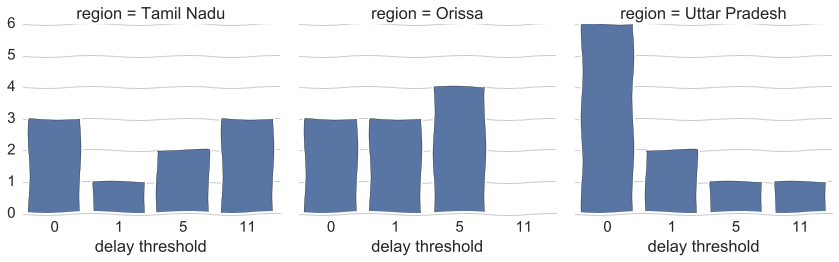

In [17]:
#--- Chart values
# set background
sns.set_style('whitegrid')
# adjust font size
sns.set_context("notebook", font_scale=1.5)
# reset data for plotting
df = opt_delay_thrs.copy(deep=True)
df['region'] = [ ' '.join(x.split('_')) for x in opt_delay_thrs.index ]
df = pd.melt(df,id_vars='region')
df['delay threshold'] = df['value'].astype('int')
# create plot
chart = sns.FacetGrid(df,col='region',size=4)
_ = chart.map(sns.countplot,'delay threshold')
sns.despine(left=True)
# save figure
plt.savefig('../figures/delay_threshold_values.png')